# 05 gVg GSEA RPE
This notebook details processes for running GSEA on DEGS obtained from gVg comparisons.

**Expected Outputs**
 - CSV file of GSEA results
 - rds of raw ClusterProfiler objects

### Initialize Environment

Import the necessary packages and output package versions:

In [1]:
# Import necessary packages
library(ggplot2)
library(clusterProfiler)
library(DOSE)
library(scales)
library(viridis)
library(dplyr)

clusterProfiler v4.14.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang,
W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize
multiomics data. Nature Protocols. 2024, 19(11):3292-3320




Attaching package: ‘clusterProfiler’




The following object is masked from ‘package:stats’:

    filter




DOSE v4.0.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an
R/Bioconductor package for Disease Ontology Semantic and Enrichment
analysis. Bioinformatics. 2015, 31(4):608-609



Loading required package: viridisLite




Attaching package: ‘viridis’




The following object is masked from ‘package:scales’:

    viridis_pal





Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Set working directory
setwd("/home/dalbao/2023-012-Runx3mutD8scRNA/AlbaoRunx3Manuscript/single_cell/05_enrichment/")

# Set input dataset (csv file)
input <- "04_25-12-08-02-33_RPE_gVg-diffExp.csv"

# Set gene set file (csv file)
gs_fn <- "genesets_v10_Ensembl98.filtered.csv"

# Gene set superlist (csv file)
gsuper_fn <- "v10_gene_superlist.csv"

# Create a timestamp for the output files
timestamp <- format(Sys.time(), "%y-%m-%d-%H-%M")

# Set filename metadata for output files
dataset  <- "RPE"
analysis <- "gVg-GSEA"

# Toggle automatic data saving
savedata <- TRUE

**Load gene sets and examine:**

In [3]:
# Load gene signatures:
sigs <- read.csv(paste("../../signatures", gs_fn, sep = "/"))

# Show top 5 rows:
head(sigs)

,gs_name,gene_symbol,EnsemblID
,<chr>,<chr>,<chr>
1,TXM_lib-8C,Abi2,ENSMUSG00000026782
2,TXM_lib-8C,Acsf3,ENSMUSG00000015016
3,TXM_lib-8C,Adam8,ENSMUSG00000025473
4,TXM_lib-8C,Ano10,ENSMUSG00000037949
5,TXM_lib-8C,Cables1,ENSMUSG00000040957
6,TXM_lib-8C,Cd9,ENSMUSG00000030342


**Load dataset and examine:**

In [4]:
# Load degs
degs <- read.csv(paste("../../csv", input, sep = "/"))

degs$group <- paste(degs$group, degs$reference, sep = "_V_")

# Process degs df, add "cluster" before each cluster number to make it a text identifier
# degs$group <- paste("Cluster", degs$group, sep = "")
# Make the column group a factor
# degs$group <- factor( degs$group,
#                       levels =c("Base",
#                                 "Null",
#                                 "WT",
#                                 "dAD",
#                                 "dID",
#                                 "dVWRPY",
#                                 "d5",
#                                 "d8",
#                                 "Naive"))

# Show top 5 rows
head(degs)

,reference,group,names,scores,logfoldchanges,pvals,pvals_adj
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Base,Naive_V_Base,Rps20,37.41201,2.039501,2.492820e-306,2.306482e-302
2,Base,Naive_V_Base,Rps29,37.11241,1.525036,1.771993e-301,6.558147e-298
3,Base,Naive_V_Base,Rpl12,37.06815,1.691264,9.161225e-301,2.825475e-297
4,Base,Naive_V_Base,Rplp1,36.66202,1.362307,2.944398e-294,7.783725e-291
5,Base,Naive_V_Base,Rps28,36.01777,1.448300,4.409637e-284,7.418212e-281
6,Base,Naive_V_Base,Rpl10,35.47642,1.745108,1.135631e-275,1.751238e-272


### Gene Set Enrichment Analysis

Perform GSEA analyses per cluster and save these analyses to a list. Moreover, prepare degs to have an ordered list suitable for clusterProfiler; order genes from highest to lowest scores. First create a function:

In [5]:
# Define a function that takes the entire degs list, a cluster of interest, and gene signatures then returns a gseaResult object.
performGSEA <- function(degs, cluster, sigs, seed = TRUE, set_seed = 42){
    # Extract cluster of interest
    cluster <- degs[degs$group == cluster, ]
    # Extract Z scores
    cluster.genes <- cluster$scores
    # Name Z scores by gene
    names(cluster.genes) <- cluster$names
    # Sort genes by decreasing score (needed for clusterProfiler)
    cluster.genes <- sort(cluster.genes, decreasing = TRUE)

    # Perform GSEA
    if(seed){
        set.seed(42) # For computational reproducibility
    }
    gsea <- GSEA(   cluster.genes,
                    TERM2GENE=sigs,
                    nPerm = 10000,
                    minGSSize = 0,
                    maxGSSize = 5000,
                    pvalueCutoff = 1,
                    by="DOSE",
                    seed = seed)

    return(gsea) # Return gseaResult object
} # End of fucntion

Now that a function is defined, loop through all clusters within degs df:

In [6]:
# Define a list to hold gseaResults
enrichment_results = list()

# Define an empty dataframe
results_df <- data.frame()

# Loop over all clusters in degs df
for(cluster in unique(degs$group)){
    # Assign gseaResult from performGSEA() to a specific item in enrichment_results
    enrichment_results[cluster] <- performGSEA(degs = degs, cluster = cluster, sigs = sigs, seed = TRUE, set_seed = 42)
    
    # Extract dataframe of results
    df <- enrichment_results[[cluster]]@result
    # Label cluster for the extracted dataframe
    df$cluster <- cluster
    # Put cluster column as the firstmost column
    df <- df[, c(12, 1:11)]

    # Rowbind dataframes to combine all clusters into one
    # Conditional, if results_df is empty, assign current df:
    if(dim(results_df)[1] == 0){
        results_df <- df
        print("Start")
    }else{ # If data exists, rowbind
        results_df <- rbind.data.frame(results_df, df)
    }

    # Show progress
    print(cluster) 

    rm(df, cluster) # Cleanup
}

results_df$BH <- p.adjust(results_df$pvalue, method = "BH")
# End of loop

preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "Start"
[1] "Naive_V_Base"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "Null_V_Base"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "WT_V_Base"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "d5_V_Base"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "d8_V_Base"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "Base_V_WT"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "Naive_V_WT"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "Null_V_WT"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "d5_V_WT"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "d8_V_WT"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "Base_V_Null"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "Naive_V_Null"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "WT_V_Null"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "d5_V_Null"


preparing geneSet collections...



calculating observed enrichment scores...



calculating permutation scores...



calculating p values...



leading edge analysis...



done...



Warning message in `[<-`(`*tmp*`, cluster, value = performGSEA(degs = degs, cluster = cluster, :
“implicit list embedding of S4 objects is deprecated”


[1] "d8_V_Null"


**Save CSV of GSEA results and the raw ClusterProfiler objects:**

In [7]:
if(savedata){
    fn <- paste("05", timestamp, analysis, dataset, sep = "_")
    # Reminder for saved data
    cat("The filename for the RDS ouput of this notebook will be:\n")
    cat(paste(fn, ".rds", sep = ""), "\n")
    cat("which will be saved in the WORKDIR/rds/ folder\n")
    
    # Save list containing gseaResult objects to RDS
    saveRDS(enrichment_results, paste("../../rds/", fn, ".rds", sep = ""))
    
    # Reminder for saved data
    cat("The filename for the CSV ouput of this notebook will be:\n")
    cat(paste(fn, ".csv", sep = ""), "\n")
    cat("which will be saved in the WORKDIR/csv/ folder\n")
    
    # Save list containing gseaResult objects to RDS
    write.csv(results_df, paste("../../csv/", fn, ".csv", sep = ""), row.names = FALSE)
}

The filename for the RDS ouput of this notebook will be:
05_25-12-08-03-54_gVg-GSEA_RPE.rds 
which will be saved in the WORKDIR/rds/ folder
The filename for the CSV ouput of this notebook will be:
05_25-12-08-03-54_gVg-GSEA_RPE.csv 
which will be saved in the WORKDIR/csv/ folder


**Save the results of the differential expression analysis in a CSV file and the modified adata file:**

### Visualize GSEA Results

**Perform cosmetic changes on gene set names:**

In [8]:
# Shorten ID names:
# results_df$ID <- gsub("Exp391_CD8---", "", results_df$ID)
# results_df$ID <- gsub("2016_SCIENCE_Mackay---", "", results_df$ID)

**Pre-process data to order clusters accordingly and filter out non-significant results:**

In [9]:
# Turn results_df$cluster into a factor to enable ordering
# results_df$cluster = factor(results_df$cluster,
#                     levels =c("Base",
#                                 "Null",
#                                 "WT",
#                                 "dAD",
#                                 "dID",
#                                 "dVWRPY",
#                                 "d5",
#                                 "d8",
#                                 "Naive"))

# Calculate negative logarithm of q-value
results_df$log_qvalue <- -log10(results_df$BH)

# Filter significant q-values
significant_df <- subset(results_df, BH < 0.05)

**Define a function to plot data:**

In [10]:
plotGSEAbubble <- function(df){
    # Define color scale
    color_scale <- c("#3c97daff", "#ddddddff", "#fe9d52ff")  # Generate a color scale with 2 colors
    
    # Create bubble plot
    p <- ggplot(df, aes(x = cluster, y = ID)) +
      geom_point(aes(color = NES, size = log_qvalue)) +
      scale_color_gradientn(
        colors = color_scale,
        limits = range(results_df$NES),
        na.value = "grey50",
        guide = guide_colorbar(title = "NES")
      ) +
      scale_size_continuous(
        breaks = seq(0, max(results_df$log_qvalue), by = 0.5),
        labels = seq(0, max(results_df$log_qvalue), by = 0.5),
        guide = guide_legend(title = "-log10(Q-value)")
      ) +
      labs(
        title = paste("Gene Set Enrichment by Cluster", name),  # Set the plot title
        x = "Cluster",  # Label for the X-axis
        y = "ID"  # Label for the Y-axis
      ) +
      theme_minimal() +  # Set the plot theme to minimal
      theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate and align X-axis labels
    return(p)
}

**Load a gene supersets and plot GSEA into supersets:**

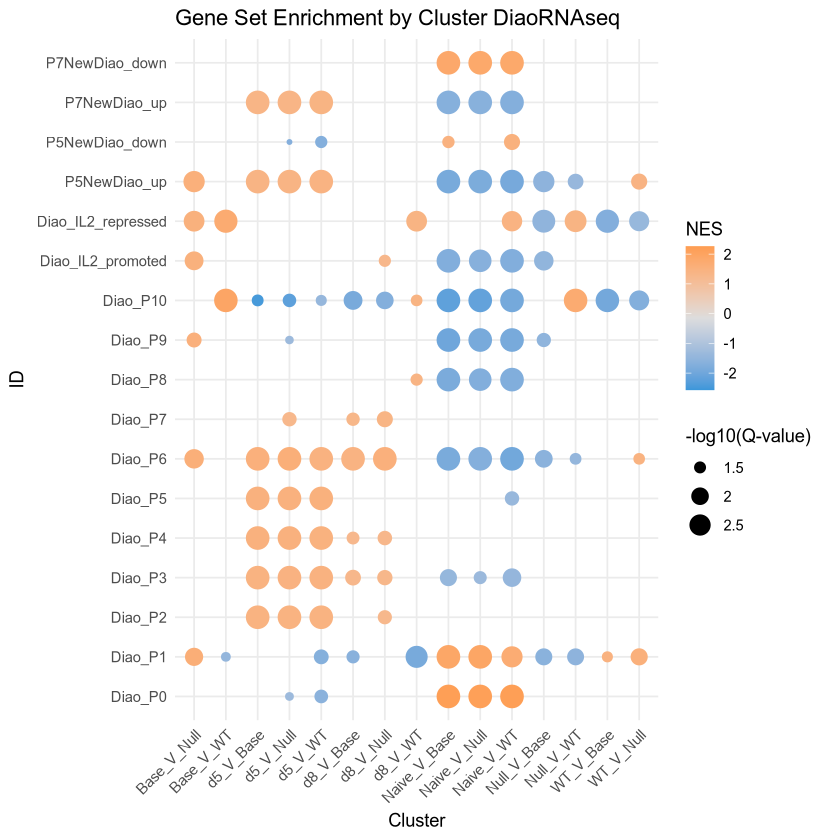

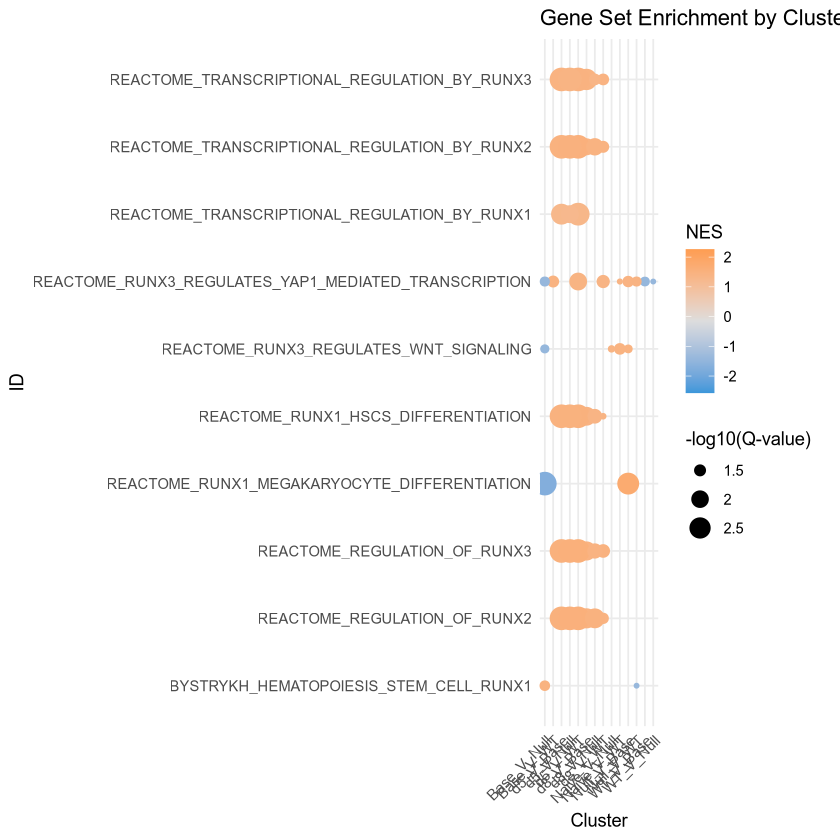

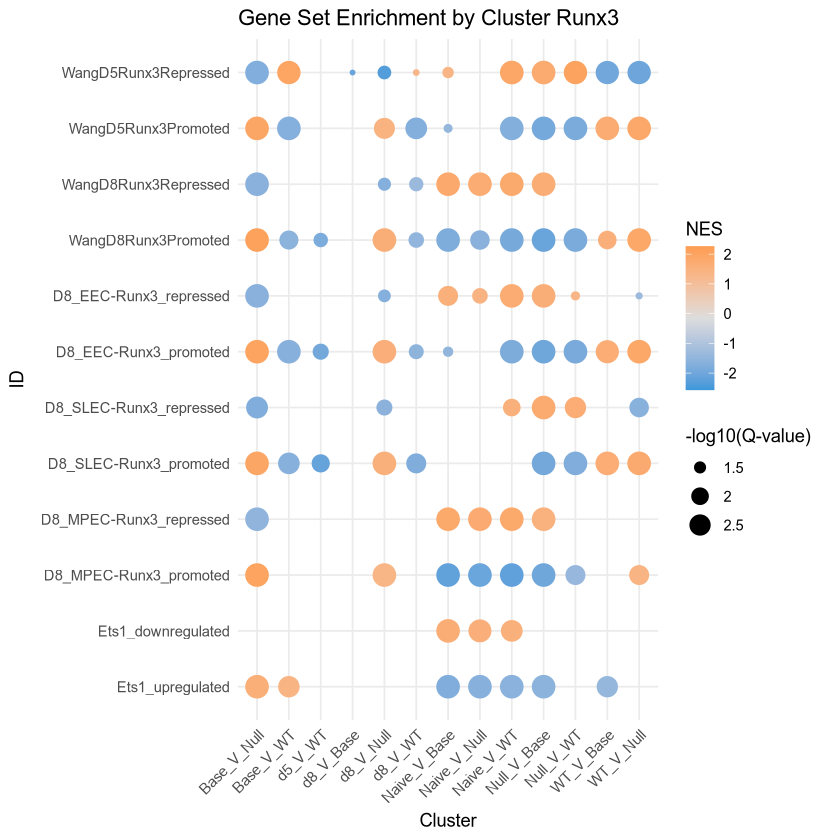

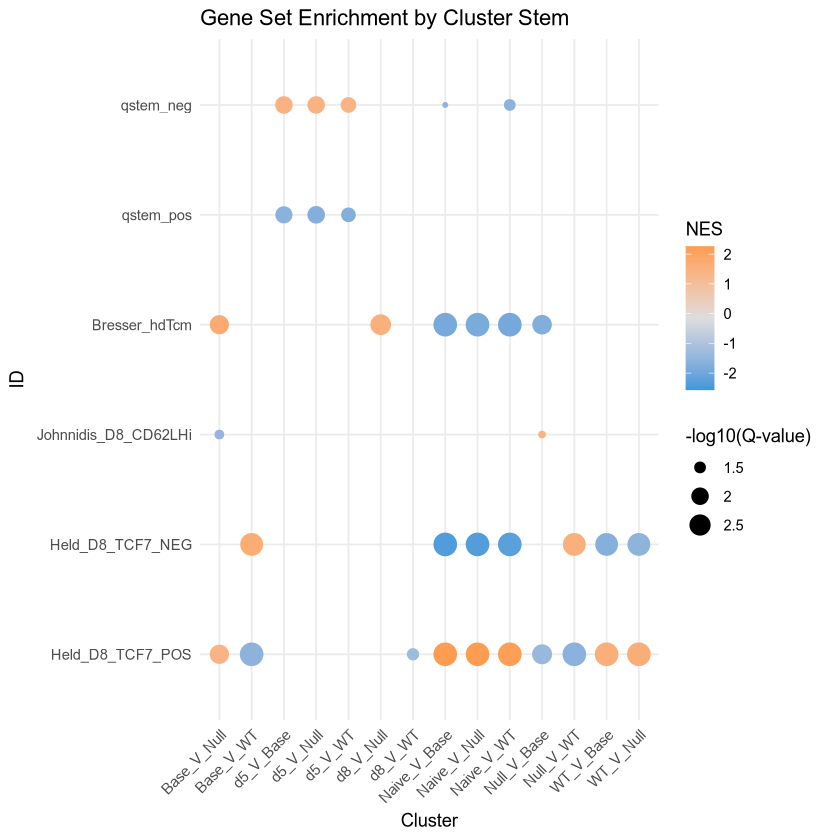

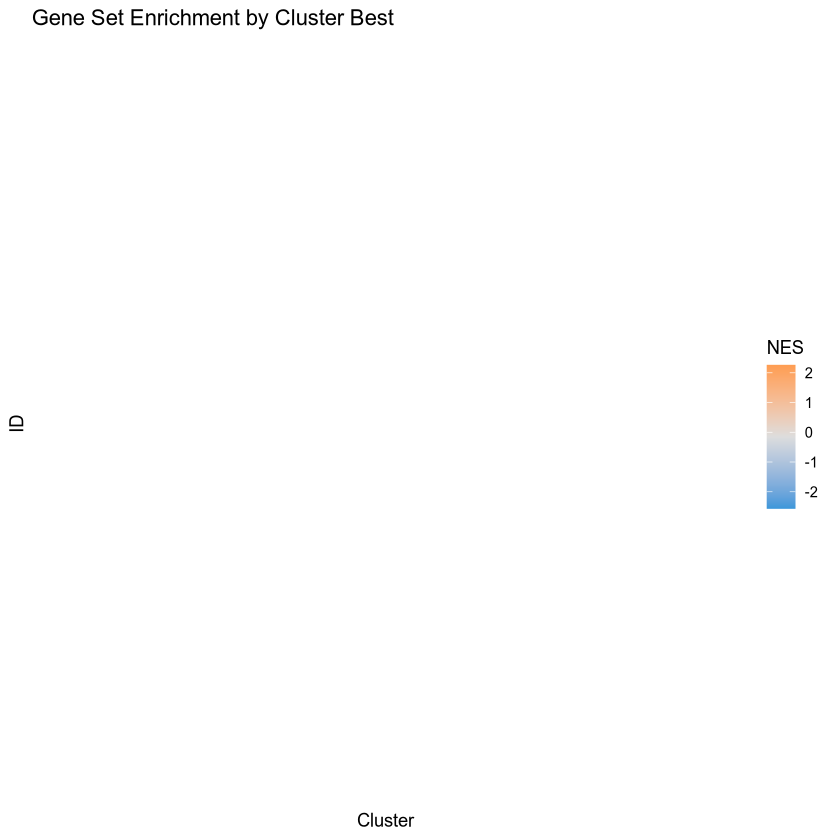

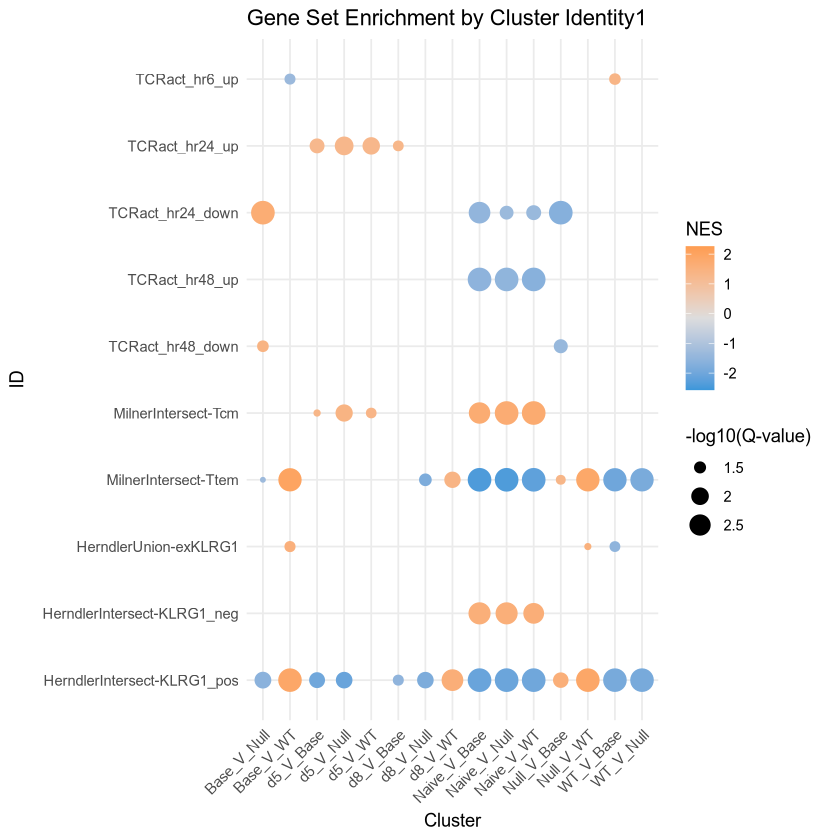

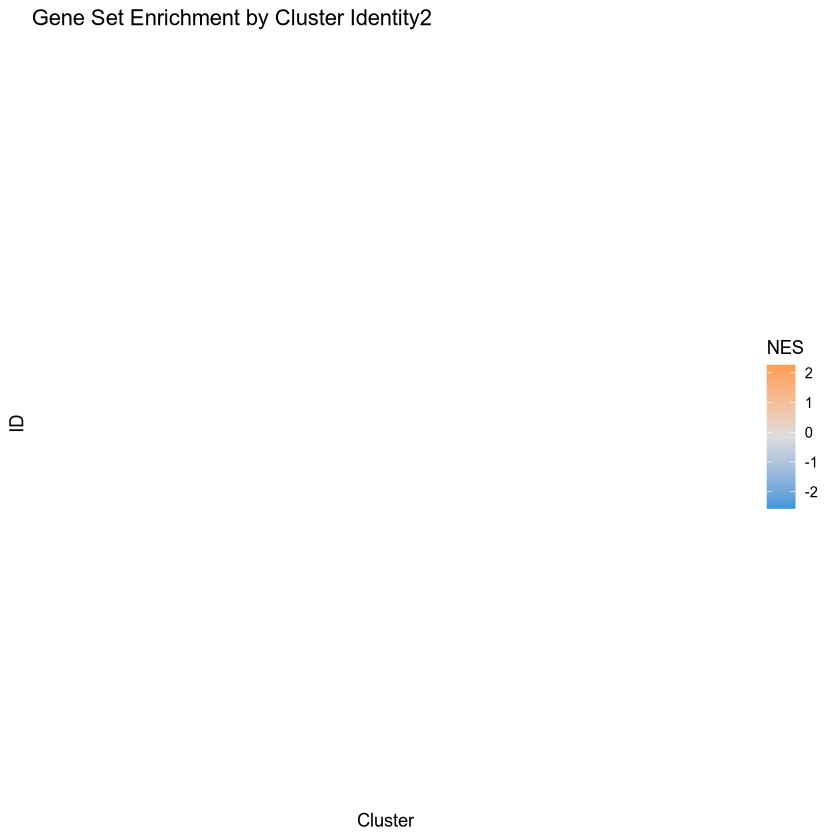

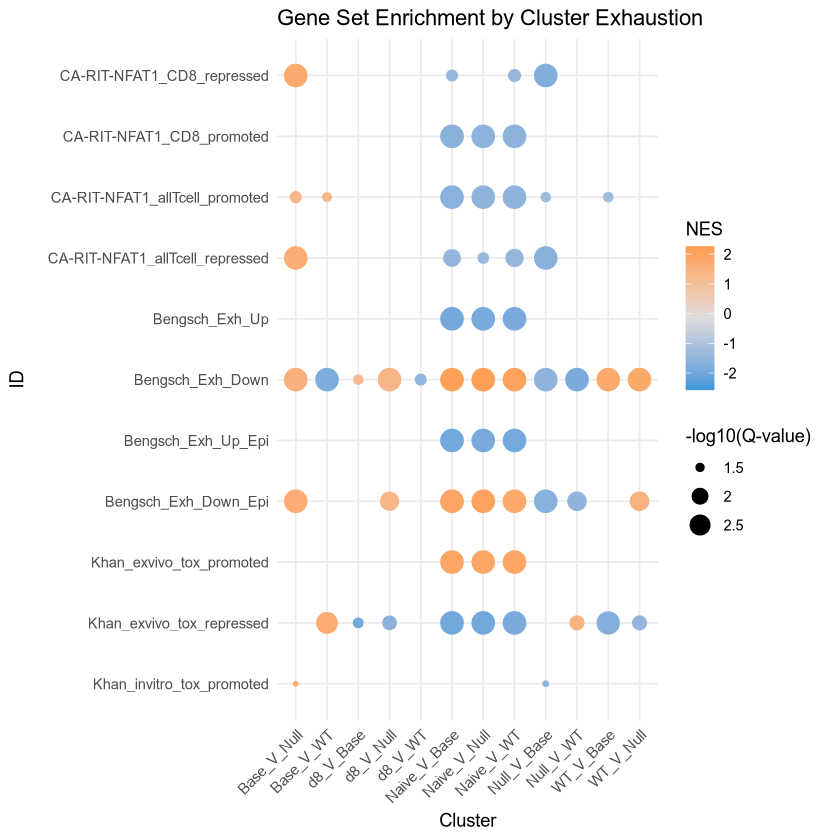

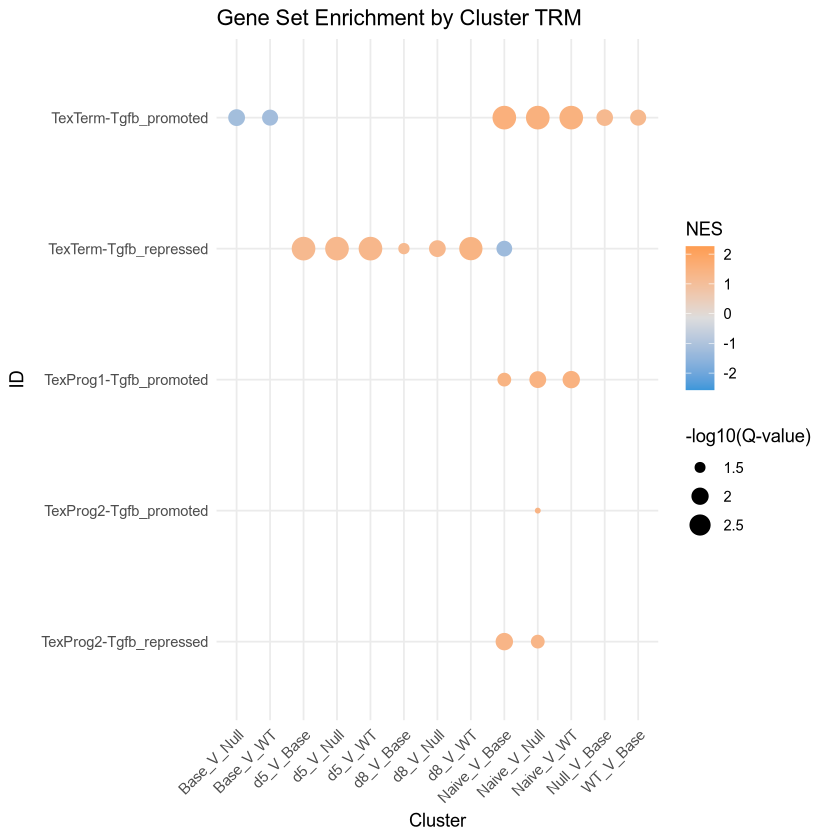

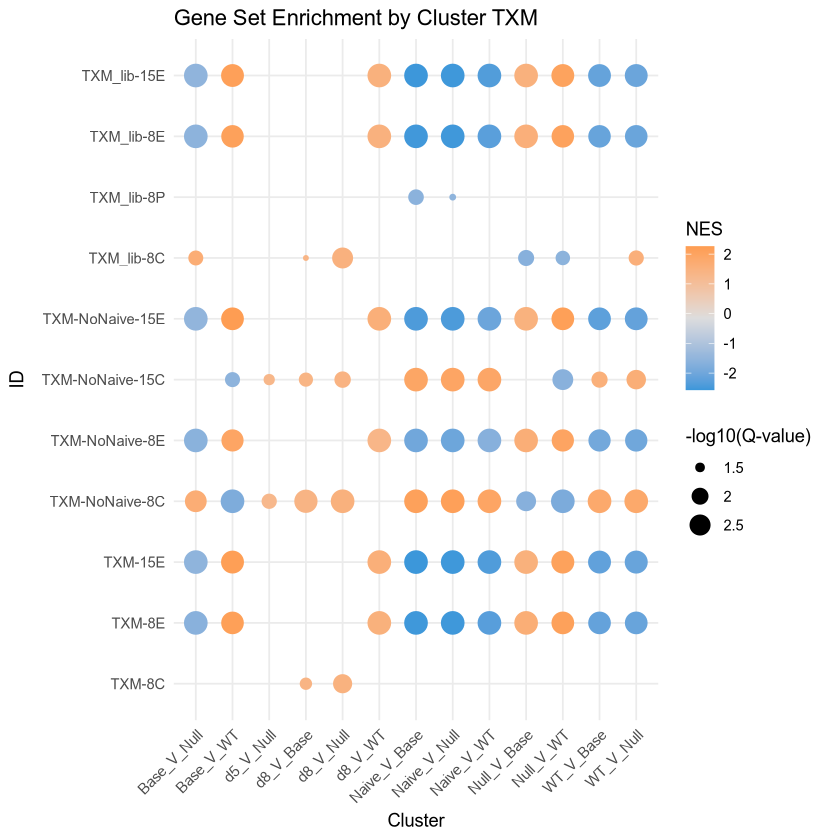

In [11]:
# Load gene super sets
superset <- read.csv(paste("../../signatures/", gsuper_fn, sep = ""))
superset[superset == ""] <- NA

superset_names <- colnames(superset)

for(name in superset_names){
    order <- na.omit(superset[name][,1])
    plot_df <- significant_df[significant_df$ID %in% order, ]
    plot_df$ID <- factor(plot_df$ID, levels = order)
    print(plotGSEAbubble(plot_df))
}